# 3k2f 60 C High Pressure

### Scaling Time

We scale time in this version of the analysis by a multiplicative factor to ensure that the time between the start time (estimated to be 10:00am 7/15/19) and the measurement time (time-stamped on the images) is equal to the final time listed on the axis of the Belsorp plot. I've estimated this factor to be around 16/15, but I will compute it precisely in the following analysis. This scaling differs from the previous approach by scaling time by a multiplicative factor instead of shifting it.

### Description of Experiment

We are repeating the measurement of the 3k2f PPG polyol at 60 C to extend our data set to higher pressure in search of interesting supercritical behaviors. Along the way we will repeat a few data points at lower pressures to assess the repeatability of measurements. The experiment was performed with manual pressure changes and used DataThief on the plot generated by the Belsorp BG software to extra gravimetry data. 

The polyol is difunctional with molecular weight ~2700 g/mol in an atmosphere of carbon dioxide. The experiment was performed in the lab of Prof. Ernesto Di Maio in the Department of Chemical Engineering, Materials, and Industrial Production (DICMaPI) at the University of Naples Federico II from July 15-24, 2019.
    
The analysis computes the **solubility, interfacial tension, and specific volume** of the sample at pressures from 0 to 80 bar at 60 C. No diffusivity data are provided because of the lack of reliable time-series data at either the beginning or the end of the sorption curve due to large fluctuations in temperature (which have a magnified effect at higher pressure).

We begin by importing the required Python libraries and setting parameters for this particular analysis.

In [1]:
import numpy as np
import pandas as pd
import csv
import matplotlib.pyplot as plt

import glob
import os
from scipy.interpolate import interp1d

import dataproc
from timedate import TimeDate

from importlib import reload
reload(dataproc)

file_template = '201907*_*_*kPa*'
metadata_file = '20190715_0724_3k2f_60c_hip_metadata.txt'
# folder for gravimetry data from DataThief analysis of Belsorp BG data plotted from Rubotherm
datathief_folder = '../../EXPERIMENTS/Italy/data/datathief/20190715_0724_3k2f_60c_hip/'
grav_folder = '../../EXPERIMENTS/Italy/data/gravimetry/'
# reference time is time when Belsorp started recording data
date_ref = '7/15/2019'
time_ref = '10:00:00'
# system parameters
polyol = '3k2f_hip'
T = 60
i_50kPa = 0

p_filepath_template = os.path.join(datathief_folder + file_template + '_p.txt')
p_file_list = glob.glob(p_filepath_template)
T_filepath_template = os.path.join(datathief_folder + file_template + '_T.txt')
T_file_list = glob.glob(T_filepath_template)
mp1_filepath_template = os.path.join(datathief_folder + file_template + '_mp1.txt')
mp1_file_list = glob.glob(mp1_filepath_template)

# initialize numpy arrays to store measured values (time,pressure, temperature, and MP1 balance reading)
t_grav = []
p_list = []
T_list = []
br_list = []
bp_list = []
time_list = []
date_list = []
# load metadata
metadata = pd.read_csv(datathief_folder + metadata_file, header=0)

# create reference date and time object
time_date_ref = TimeDate()
time_date_ref.load_string(date_ref, time_ref)
# load data from each file
for i in range(len(p_file_list)):
    # extract filepaths for pressure, temperature, and MP1 balance reading
    p_file = p_file_list[i]
    T_file = T_file_list[i]
    mp1_file = mp1_file_list[i]
    # load data
    t_p, p = dataproc.load_datathief_data(p_file)
    t_T, T_ = dataproc.load_datathief_data(T_file)
    t_mp1, mp1 = dataproc.load_datathief_data(mp1_file)
    # remove repeats and interpolate values so spacing is even
    t_p_interp, p_interp = dataproc.interp(t_p, p, dt=2)
    t_T_interp, T_interp = dataproc.interp(t_T, T_, dt=2)
    t_mp1_interp, mp1_interp = dataproc.interp(t_mp1, mp1, dt=2)
       
    # identify pressure step as a reference point in time to synchronize different runs
    t_mult = dataproc.compute_t_multiplier(metadata, i, t_p_interp, date_ref, time_ref)
        
    # synchronize times of all measurements using only times that overlap
    t_min = np.max([np.min(t_p), np.min(t_T), np.min(t_mp1)])
    t_max = np.min([np.max(t_p), np.max(t_T), np.max(t_mp1)])
    # remove repeats and interpolate values so spacing is even (all interpolated times should be the same)
    t_p_interp, p_interp = dataproc.interp(t_p, p, dt=2, t_min=t_min, t_max=t_max)
    t_T_interp, T_interp = dataproc.interp(t_T, T_, dt=2, t_min=t_min, t_max=t_max)
    t_mp1_interp, mp1_interp = dataproc.interp(t_mp1, mp1, dt=2, t_min=t_min, t_max=t_max)
    
    t_mult = 1.052
    # scale time
    t_p_interp *= t_mult
    
    # concatenate data
    zero_last = i != i_50kPa # accidentally took zero measurement first for 50 kPa
    dataproc.concatenate_data(metadata, i, date_ref, time_ref, time_list, date_list, 
                     t_grav, t_p_interp, p_interp, p_list, T_interp, T_list, 
                     mp1_interp, br_list, bp_list, zero_last=zero_last)
    
# save results in TRD file format
df_trd = pd.DataFrame(columns=['DATE', 'TIME', 'Julabo_Ext_PV', 'WEITGHT(g)', 'BALANCE POSITION', 'Now Pressure(kPa)'])
df_trd['DATE'] = date_list
df_trd['TIME'] = time_list
df_trd['Julabo_Ext_PV'] = T_list
df_trd['WEITGHT(g)'] = br_list
df_trd['BALANCE POSITION'] = bp_list
df_trd['Now Pressure(kPa)'] = p_list
trd_save_hdr = grav_folder + '%s_%dc-TRD-071519-1000' % (polyol, T) # 1000 indicates the reference time 10:00

# save csv file with TRD header
dataproc.save_trd(df_trd, trd_save_hdr)

Having created an artificial TRD file in the format that would have been produced by the Belsorp program during an automatic test, we can now proceed through the analysis as usual.

In [2]:
import errprop
import plot

reload(dataproc)
reload(errprop)


# SET PARAMETERS
# folder for ADSA data
adsa_folder = '../../EXPERIMENTS/Italy/data/adsa/20190715_0724_3k2f_hip/'
# list of data files with pendant drop volume (only) for ADSA generated from videos of a pendant drop
adsa_volume_file_list = ['20190716_0717_3k2f_60c_hip_adsa_volume.csv', '20190718_0719_3k2f_60c_hip_adsa_volume.csv',
                        '20190719_3k2f_60c_hip_adsa_volume.csv', '20190719_0720_3k2f_60c_hip_adsa_volume.csv',
                        '20190722_3k2f_60c_hip_adsa_volume.csv', '20190722_0723_3k2f_60c_hip_adsa_volume.csv',
                        '20190723_0724_3k2f_60c_hip_adsa_volume.csv']
# list of data files with interfacial tension data--leave blank if not complete
adsa_if_tension_file_list = ['20190716_0717_3k2f_60c_hip_adsa_if_tension.csv', '20190718_0719_3k2f_60c_hip_adsa_if_tension.csv',
                            '20190719_3k2f_60c_hip_adsa_if_tension.csv', '20190719_0720_3k2f_60c_hip_adsa_if_tension.csv']
# filepath to gravimetry data 
grav_filepath = trd_save_hdr + '.csv'
# file path to save results
save_folder = '../g-adsa_results/'
save_data_name = '3k2f_60c_hip.csv'
save_plots = True
# list of starting times of ADSA data relative to start of gravimetry data
# gravimetry 7/15 13:04; adsa videos: 14:27, 7/16; 19:18, 7/17; 14:14, 7/18; 9:16, 7/19; 16:48, 7/19
# adsa_time_list = ['14:27:00', '19:18:00', '14:14:00', '9:16:00', '16:48:00', '10:02:00', '18:15:00', '16:02:00', '15:35:00']
# adsa_date_list = ['7/16/2019', '7/17/2019', '7/18/2019', '7/19/2019', '7/19/2019', '7/22/2019', '7/22/2019', 
#                   '7/23/2019', '7/24/2019']
adsa_time_list = ['14:27:00', '14:14:00', '9:16:00', '16:48:00', '10:02:00', '18:15:00', '16:02:00']
adsa_date_list = ['7/16/2019', '7/18/2019', '7/19/2019', '7/19/2019', '7/22/2019', '7/22/2019', 
                  '7/23/2019']
# number of minutes of measurements to average for surface tension and volume readings
n_minutes = 120
# number of measurements to average (if the method using minutes doesn't work)
n_adsa = 20

# polyol code name
polyol = '3k2f_hip'
# weight of sample in atmospheric pressure, measured with analytical balance on 7/5/19 [g]
w_samp_atm = 1.1153
# volume of drop in atmospheric pressure, from 20190716_3k2f_60c_atm_snapshot.mdb [uL]
v_drop_atm = 4.136
# volume of drop under vacuum, from 20190716_3k2f_60c_0bar_snapshot.mdb [uL]
v_drop_0 = 4.116
# density of polyol sample from Dow technical data sheet at atmospheric pressure and 25 C (TDS)
# and extrapolated using P-1000 Dow data [g/mL]
rho_samp_atm = 0.977
# volume of hook and crucible as measured in helium [mL]
v_ref_he = 2.2674 # extrapolated from measurement by Maria Rosaria Di Caprio @ 25 C [mL]
diam_cruc = 1.82 # diameter of crucible [cm]
br_cruc = 7.2788 - 0.0003 # balance reading of crucible without polymer at atmospheric pressure [g]
# measurements made manually with Rubotherm on 7/16/19 at 60 C
mp1_atm = 14.02994
zero_atm = 5.63404
# ordered list of pressure set points (within p_thresh_frac of true values) [kPa]
p_set_arr = metadata['p set [kPa]'].to_numpy(dtype=float)
p_thresh_frac = 0.04 # threshold for acceptable difference between actual pressure and set pressure [fraction]
# resolution of pressure measurement [kPa]
p_resolution = 1
# number of measurements of pressure within equilibrium (2 min per measurement --> 30 minutes, 2-3 cycles of temperature,
# which fluctuated every 10-15 minutes.)
n_p_eq = 50

# CONSTANTS
# Set-point temperature [C]
T = 60
# atmospheric pressure [kPa]
P_ATM = 101.3
# density of air at sea level acc. to https://www.engineeringtoolbox.com/standard-atmosphere-d_604.html [g/mL]
RHO_AIR = 1.225E-3
# mass of crucible and hooks measured June 26 with Rubotherm in atmosphere [g]
TARE = 7.2788 - 0.0003 + RHO_AIR*v_ref_he 

# NOTE: PARAMETERS FOR ERROR PROPAGATION ARE DECLARED IN THE "ERROR PROPAGATION" SECTION

We first compute the time delay from the reference time of the experiment (roughly the beginning) to the beginning of each ADSA measurement.

In [3]:
# initialize list of time delays until the start of the ADSA measurements
adsa_t0_list = []
# use TimeDate class to compute seconds of delay between the times and dates provided
for i in range(len(adsa_time_list)):
    adsa_time = adsa_time_list[i]
    adsa_date = adsa_date_list[i]
    adsa_td = TimeDate(date_str=adsa_date, time_str=adsa_time)
    # compute seconds after reference time that ADSA was started
    adsa_t0_list += [TimeDate.diff_min(time_date_ref, adsa_td)*60]

## Load Raw Data

Next we load the raw data from gravimetry and ADSA that we wish to process.

In [4]:
reload(dataproc)
# load (and validate) raw data
df, br_arr, bp_arr, p_arr, t_grav, v_drop, t_adsa = dataproc.load_raw_data(adsa_folder, adsa_volume_file_list, 
                                                                      adsa_t0_list, grav_filepath, p_set_arr, zero_t_grav=False,
                                                                          time_date_ref=time_date_ref)
# convert times from seconds to minutes
t_adsa /= 60
t_grav = t_grav / 60.
df.head()

,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,dissolved gas balance reading [g],buoyancy correction [g],actual weight of dissolved gas [g],solubility [w/w],solubility error [w/w],specific volume [mL/g],specific volume error [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (exp) [cm^2/s],diffusion time constant [s]
0,45.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1330.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5500.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6200.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### Plot Drop Volume over Time Alongside Pressure

To determine if the gravimetry and ADSA data are accurately synchronized, I will plot the drop volume alongside the pressure. Changes in pressure should be quickly followed by the appropriate change in drop volume.

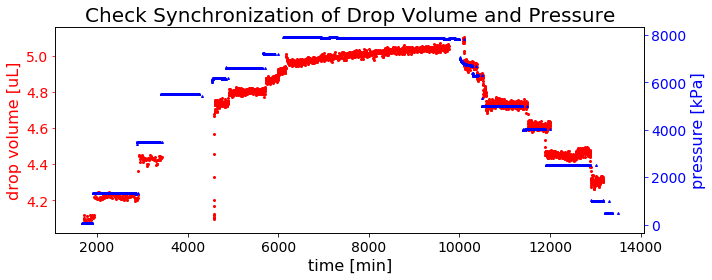

In [5]:
reload(plot)
plot.plot_two_axes(t_adsa, v_drop, p_arr, x2=t_grav, figsize=(10,4), labels=['drop vol', 'p'], xlabel='time [min]', ms=2, 
                   ylabels=['drop volume [uL]', 'pressure [kPa]'], title='Check Synchronization of Drop Volume and Pressure')

## Synchronize Gravimetry and ADSA Measurements

In the next section, we synchronize gravimetry and ADSA measurements and identify their corresponding pressures. We then average the final values of the measurements of mass, tare, and interfacial tension (and take the standard deviation as an estimate of the error) and save them for further analysis.

Pressure = 45 kPa.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Drop volume = 4.097133 uL.
Pressure = 1330 kPa.
Rejected 1 outliers.
Drop volume = 4.226067 uL.
Pressure = 3500 kPa.
Drop volume = 4.422533 uL.
Pressure = 5500 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
********not enough ADSA points at given pressure.******
Drop volume = 4.423667 uL.
Pressure = 6200 kPa.
Rejected 1 outliers.
Drop volume = 4.730067 uL.
Pressure = 6600 kPa.
Rejected 1 outliers.
Drop volume = 4.805800 uL.
Pressure = 7200 kPa.
Rejected 1 outliers.
Drop volume = 4.870733 uL.
Pressure = 7850 kPa.
7850.0
0.01
Rejected 1 outliers.
Drop volume = 5.027867 uL.
Pressure = 6700 kPa.
Rejected 1 outliers.
Drop volume = 4.956600 uL.
Pressure = 6300 kPa.
Rejected 1 outliers.
Drop volume = 4.890000 uL.
Pressure = 5000 kPa.
Rejected 1 outliers.
Drop volume = 4.728800 uL.
Pressure = 4000 kPa.
Rejected 1 outliers.
Drop volume = 4.602200 uL.
Pressure = 2500 kPa.
Rejected 1 outliers.
Drop volume = 4.459800 uL.
Pressure = 1000 kPa.
Rejected 1 outliers.


,p set [kPa],p actual [kPa],p std [kPa],zero [g],zero std [g],mp1 [g],mp1 std [g],mp2 [g],mp2 std [g],M_0 (extrap) [g],...,dissolved gas balance reading [g],buoyancy correction [g],actual weight of dissolved gas [g],solubility [w/w],solubility error [w/w],specific volume [mL/g],specific volume error [mL/g],diffusivity (sqrt) [cm^2/s],diffusivity (exp) [cm^2/s],diffusion time constant [s]
0,45.0,45.1745,1,5.63332,1e-05,14.0267,0.000154919,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1330.0,1333.33,1,5.61248,1e-05,13.9463,0.00462552,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3500.0,3496.92,1,5.57332,1e-05,13.8031,0.00814494,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5500.0,5493.83,1,5.52911,1e-05,13.6444,0.00778311,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,6200.0,6156.31,12.5476,5.51185,1e-05,13.5397,0.0192997,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


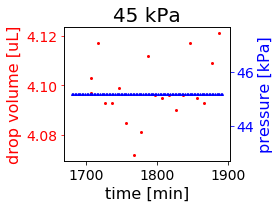

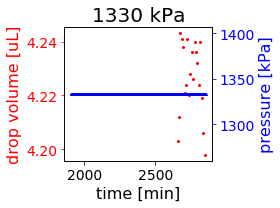

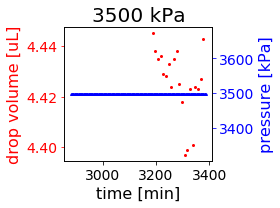

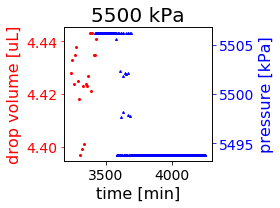

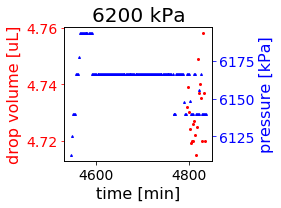

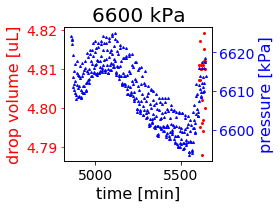

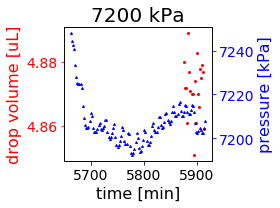

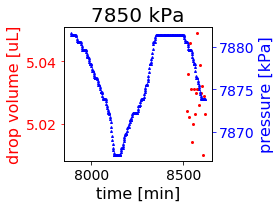

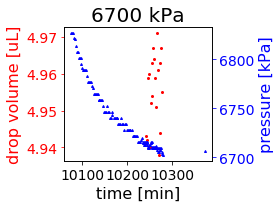

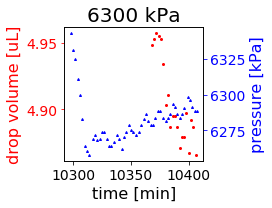

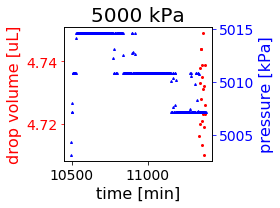

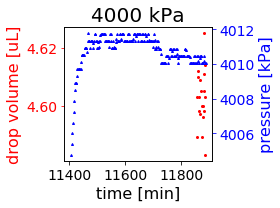

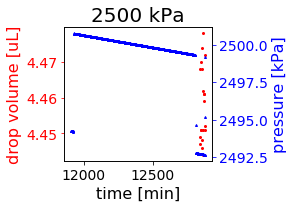

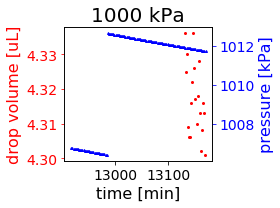

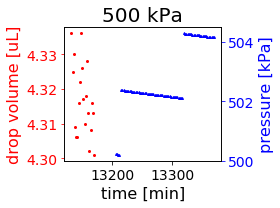

In [6]:
reload(dataproc)
# Identify boundaries of pressure intervals and store gravimetry and ADSA data together after synchronization
# initalize marker for pressure bounds
i_p1 = 0
focus_on_step = False
select_index = 10
plot_p = False
# extract interfacial tension, drop volume, and mass at MP1 for each pressure
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    if p_set == np.max(p_set_arr):
        window_reduction = 0.01
        print(p_set)
        print(window_reduction)
    else:
        window_reduction = 0.25
    # get indices of each measurement with pressure within thresholds--I checked and it finds the end within 2 or 3 pts.
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1, window_reduction=window_reduction)
    # take mean and standard deviation of final pressure near equilibrium
    p_eq = p_arr[max(i_p0, i_p1-n_p_eq):i_p1]
    df['p actual [kPa]'].iloc[i] = np.mean(p_eq)
    df['p std [kPa]'].iloc[i] = max(np.std(p_eq), p_resolution)

    if plot_p:
        # PLOT PRESSURE TO DEBUG IDENTIFICATION OF PRESSURE STEPS
        plot.plot_line(t_grav[i_p0:i_p1], p_arr[i_p0:i_p1], xlabel='time [s]', ylabel='pressure [kPa]',
                 title='Pressure at set point {0} kPa'.format(p_set))
    # store results in data frame
    # use times to determine indices of ADSA to use
    i_adsa = dataproc.get_inds_adsa(t_adsa, t_grav, i_p0, i_p1, n_adsa)
    plot.plot_two_axes(t_adsa[i_adsa], v_drop[i_adsa], p_arr[i_p0:i_p1], x2=t_grav[i_p0:i_p1], figsize=(4,3), 
                       labels=['drop vol', 'p'], xlabel='time [min]', ms=2, 
                   ylabels=['drop volume [uL]', 'pressure [kPa]'], title='%d kPa' % p_set)

    df = dataproc.store_grav_adsa_manual(df, metadata, i, i_p0, i_p1, t_grav, t_adsa, br_arr, bp_arr, v_drop, n_minutes, n_p_eq,
                                        date_ref, time_ref, ref_by_dp=False)

df.head()

## Analysis

Next we perform the analysis of the gravimetry and ADSA data to compute the solubility, diffusivity, interfacial tension, and specific volume. We begin with the solubility.

#### Estimation of Polymer Mass and Volume under Vacuum

Before estimating the solubility, I must compute the mass and volume of the polymer under vacuum. Since I did not take a measurement with the balance under vacuum, I will extrapolate the balance reading using measurements made at atmospheric pressure and 50 kPa, assuming a linear change in the balance reading at such low pressures.

In [7]:
# balance readings at equilibrium 
br_eq = df['mp1 [g]'].to_numpy(dtype=float) - df['zero [g]'].to_numpy(dtype=float)
# balance reading at atmospheric pressure made before starting the tests
br_eq_atm = mp1_atm - zero_atm
# (extract value at 50 kPa) [g]
br_eq_50kPa = br_eq[0]
# extrapolate balance reading at 0 kPa assuming Henry's Law [g]
# also assumes that balance reading in atmosphere (air) would not be substantially different
# if it were in CO2 because of the small amount of dissolved gas in the polyol at p = p_atm
p_50kpa = df['p actual [kPa]'].iloc[i_50kPa]
br_eq_0 = br_eq_50kPa - p_50kpa*(br_eq_atm - br_eq_50kPa)/(P_ATM - 50)
# balance reading for the mass of dissolved gas (must be corrected by buoyancy) [g]
br_gas = br_eq - br_eq_0
df['dissolved gas balance reading [g]'] = br_gas

# volume of sample under atmospheric pressure
v_samp_atm = w_samp_atm / rho_samp_atm
# APPROXIMATE weight of gas at atmosphere by subtracting extrapolated balance reading at 0 kPa
w_gas_atm = (br_eq_atm - br_eq_0) + dataproc.rho_co2(P_ATM, T)*(v_samp_atm + v_ref_he)
# APPROXIMATE weight of polymer by subtracting approximated weight of gas from weight of sample at atmosphere
w_poly_ad_hoc = w_samp_atm - w_gas_atm
print('Dry polymer mass from ad hoc extrap = %3f g vs. mass of polymer at atmospheric pressure = %3f g.' % \
      (w_poly_ad_hoc, w_samp_atm))

# compare result to that obtained by using tare measurement of crucible and hook
w_poly = br_eq_0 - TARE
print("Dry polymer mass estimated using tare measurement = " + str(w_poly) + ' g.')
# Volume of sample under vacuum ("dry" polyol) by extrapolating from the volume at 0 pressure
v_poly = v_drop_0 / v_drop_atm * v_samp_atm
print('Volume of dry polymer in crucible is approximately ~ %3f mL (using atmospheric density).' % v_poly)

############################################################################################################
# because the mass estimated using the tare measurement is greater than the atmospheric mass weighed with the
# analytical balance, we will use the ad hoc expression in this case
w_poly = w_poly_ad_hoc

Dry polymer mass from ad hoc extrap = 1.105093 g vs. mass of polymer at atmospheric pressure = 1.115300 g.
Dry polymer mass estimated using tare measurement = 1.10992094864522 g.
Volume of dry polymer in crucible is approximately ~ 1.136036 mL (using atmospheric density).


### Drop Volume and Sample Volume

Below we plot the measurements of the drop volume and use them to estimate the sample volume (we assume the drop volume increases by the same amount as the sample volume).

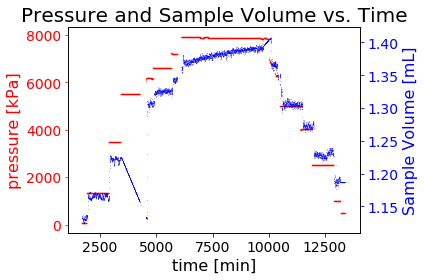

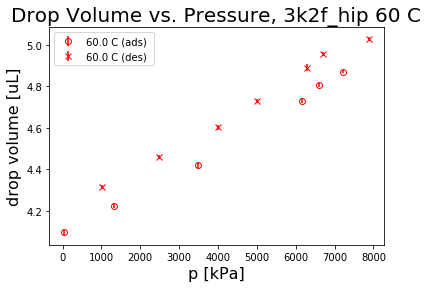

In [8]:
reload(plot)
# Drop volume [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
v_samp = v_drop_eq / v_drop_atm * v_samp_atm
df['sample volume [mL]'] = v_samp

# compute live change in volume
v_samp_adsa = v_drop / v_drop_atm * v_samp_atm
v_samp_grav = np.interp(t_grav, t_adsa, v_samp_adsa)
inds_pos = t_grav > 0
plot.plot_two_axes(t_grav[inds_pos], p_arr[inds_pos], v_samp_grav[inds_pos], labels=[r'$p$', r'$V_{samp}$'], xlabel='time [min]', 
                   ms=0.1, ylabels=['pressure [kPa]', 'Sample Volume [mL]'], title='Pressure and Sample Volume vs. Time')

# extract data to plot
p_plot = df['p actual [kPa]'].to_numpy(dtype=float)
s_drop_vol = df['drop volume std [uL]'].to_numpy(dtype=float)
# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_drop_vol, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))
if save_plots:
    plt.savefig(save_folder + 'drop_vol_%s_%dc.pdf' % (polyol, T), bbox_inches='tight') 

#### Fitting Drop Volume to Quadratic Curve to Reduce Error in Specific Volume

Prof. Di Maio suggested fitting the drop volume to a quadratic curve to reduce uncertainty introduced by experimental errors. By reducing uncertainty in the drop volume, we will reduce the error in the sample volume, and thus in the specific volume measurement, which is too high to distinguish any non-monotonic trend in the pressure that we might expect (a variation of about 5% based on the PCL/CO2 paper by Carbone et al. (2012) *J. Supercrit. Fl.*

This method greatly reduces the statistical error but the errors are smaller than the systematic error.

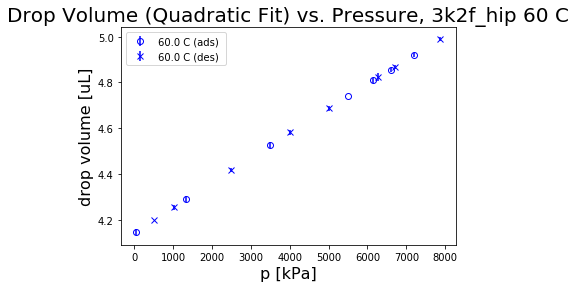

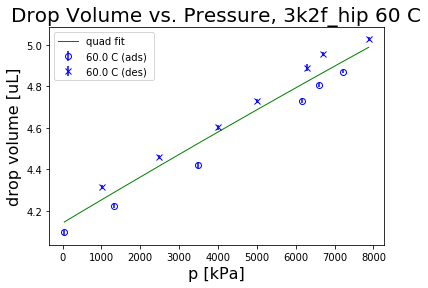

In [9]:
# remove nans
inds_not_nan = np.logical_not(np.isnan(s_drop_vol))
p_plot_2_fit = p_plot[inds_not_nan]
v_drop_eq_2_fit = v_drop_eq[inds_not_nan]
s_drop_vol_2_fit = s_drop_vol[inds_not_nan]

# fit drop volume vs. pressure with quadratic fit
i_sort = np.argsort(p_plot[1:])
coeffs, Cov = np.polyfit(p_plot_2_fit, v_drop_eq_2_fit, 2, w=1/s_drop_vol_2_fit, cov=True)
a, b, c = coeffs

def drop_vol_fit(p, a=a, b=b, c=c):
    drop_vol = a*p**2 + b*p + c
    return drop_vol

v_drop_fit = drop_vol_fit(p_plot)


# plot equilibrium drop volume vs. p (blue color for cool temperature data)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_fit, s_drop_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume (Quadratic Fit) vs. Pressure, %s %d C' % (polyol, T))

# plot equilibrium drop volume vs. p alongside the fit (blue color for cool temperature data)
inds_sort = np.argsort(p_plot)
ax = plot.plot_errorbars_ads_des(p_plot, v_drop_eq, s_drop_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='drop volume [uL]', title='Drop Volume vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_line(p_plot[inds_sort], v_drop_fit[inds_sort], ax=ax, marker=None, lw=1, color='g', label='quad fit')
plt.legend()

# Use fitted drop volume to estimate the sample volume
v_samp_fit = v_drop_fit / v_drop_atm * v_samp_atm

To compare with the previous 3k2f 60 C test, I will plot the percent of swelling of each test below.

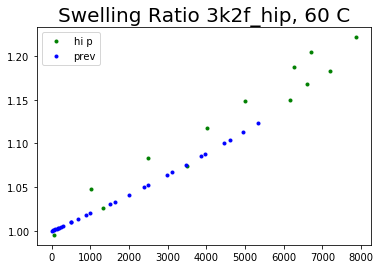

In [10]:
v_swell = v_drop_eq_2_fit / v_drop_0
ax = plot.plot_line(p_plot_2_fit, v_swell, lw=0, color='g', label='hi p')

df_prev = pd.read_csv('..\\g-adsa_results\\3k2f_60c_lop.csv')
p_prev = df_prev['p actual [kPa]'].to_numpy(dtype=float)
v_drop_prev = df_prev['drop volume [uL]'].to_numpy(dtype=float)
v_swell_prev = v_drop_prev / v_drop_prev[0]
ax = plot.plot_line(p_prev, v_swell_prev, lw=0, color='b', ax=ax, label='prev', title='Swelling Ratio %s, %d C' % (polyol, T))
plt.legend()

The percent swelling seems to match only for the adsorption stage, whereas the percent swelling during desorption is a few percent higher.

### Error Propagation

To perform error propagation, we define the following uncertainties, which will be used by subroutines later.

In [11]:
reload(errprop)

# set parameters for error propagation
n = len(p_set_arr)
w_poly_arr = w_poly*np.ones([n])
s_v_drop = df['drop volume std [uL]'].to_numpy(dtype=float)
s_frac_rho_co2 = df['p std [kPa]'].to_numpy(dtype=float)/ \
                    df['p actual [kPa]'].to_numpy(dtype=float)  # fractional uncertainty in density is roughly that of p @ eq
w_samp_ref = w_samp_atm*np.ones([n]) # analytical balance measurement of polyol [g]
s_w_samp_ref = 0.00001*np.ones([n]) # error in analytical balance measurement [g]
rho_samp_ref = rho_samp_atm*np.ones([n]) # [g/mL]
s_rho_samp_ref = 0.01*np.ones([n]) # based on density to 2 decimal places from Dow TDS and small temperature diff (25-->30.5 C) [g/mL]
v_samp_ref = v_samp_atm*np.ones([n]) # [mL]
v_drop_ref = v_drop_atm*np.ones([n]) # approximation of volume of drop at atmospheric pressure w/ p = 130 kPa [uL]
s_v_drop_ref = 0.05*np.ones([n])
v_ref = v_ref_he*np.ones([n]) # [mL]
s_v_ref = 0.01*np.ones([n]) # estimated error in tare volume using He measurement at 35 C [mL]
s_mp1 = df['mp1 std [g]'].to_numpy(dtype=float)
s_zero = df['zero std [g]'].to_numpy(dtype=float)
s_w_gas_ref = 0.00001*np.ones([n]) # ??? [g]

### Correcting for Pressure Fluctuations

At higher pressures, the fluctuations in the temperature of the cell (about 0.1-0.2 C) caused by the cycle of the air conditioning system in the laboratory can cause significant fluctuations in the measuring point 1 (MP1) balance reading. To correct for these fluctuations, I will perform a "live" buoyancy correction at each data point.

Pressure = 45 kPa.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Pressure = 1330 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 3500 kPa.
Pressure = 5500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 6200 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 6600 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 7200 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 7850 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 6700 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 6300 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 5000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 4000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 2500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 1000 kPa.
Rejected 1 outliers.
Rejected 1 outliers.
Pressure = 500 kPa.
Rejected 1 outliers.
Rejected 1 outliers.


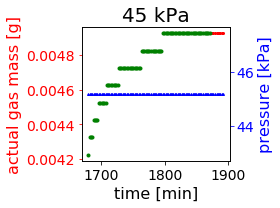

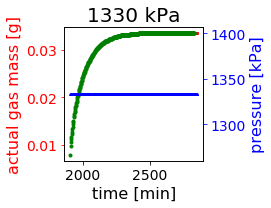

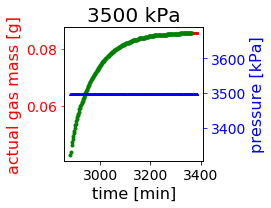

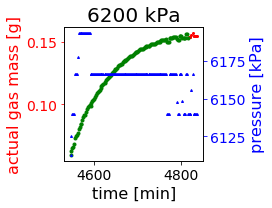

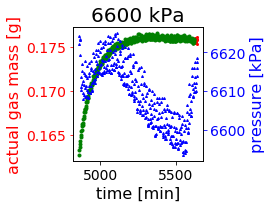

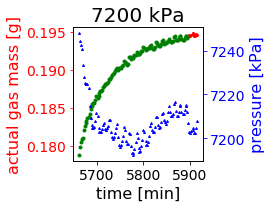

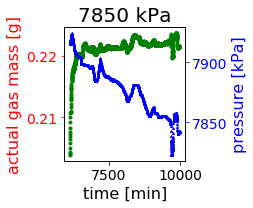

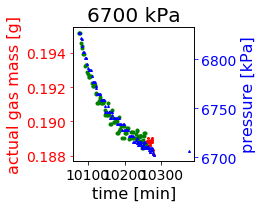

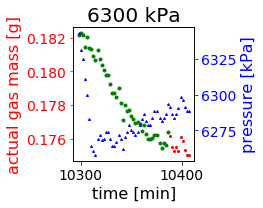

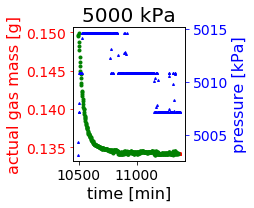

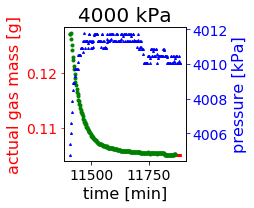

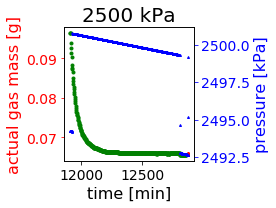

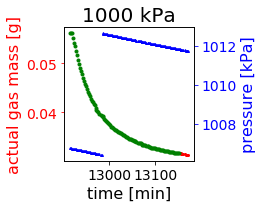

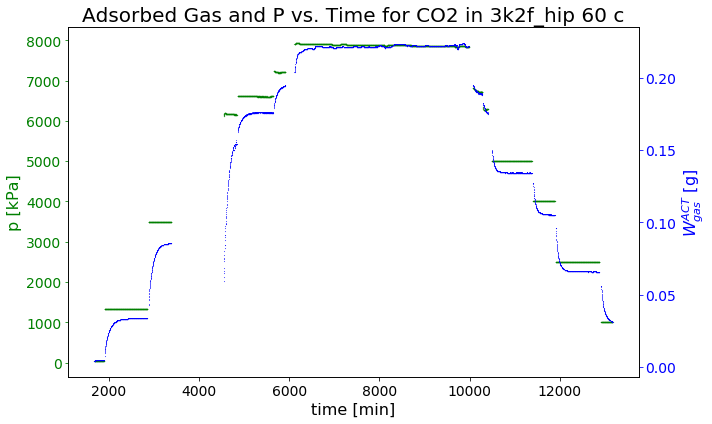

In [12]:
reload(plot)
reload(dataproc)
# parameters to insert at beginning
n_minutes = 20
# Set plot parameters
lw = 2
ax_fs = 16
t_fs = 20
tk_fs = 14
colors = ['g', 'b']
line_styles = ['--',  '-']
ms = 0.2
x_lim = [80000, 400000]
y_lim = [7.88, 7.9]

# initalize marker for pressure bounds
last_bound = 0
# initialize arrays to store data
t_mp1_arr = np.array([])
w_gas_act_arr = np.array([])
p_mp1_arr = np.array([])
M_0_prev = np.zeros([len(p_set_arr)])
M_infty_final = np.zeros([len(p_set_arr)])
# Loop through each pressure set point
for i in range(len(p_set_arr)):
    p_set = p_set_arr[i]
    print('Pressure = %d kPa.' % p_set)
    
    i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=last_bound)
    # compute actual mass of gas at the times corresponding to the current pressure, save data in data frame
    w_gas_act, t_mp1, df, last_bound, p_mp1 = dataproc.compute_gas_mass(i, T, p_arr, p_set_arr, df, bp_arr, br_arr, br_eq_0,
                                                                        t_grav, p_thresh_frac, last_bound, v_ref_he, 
                                                                        get_inst_buoy=True)

    # skip analysis if there are "nan"s in the data
    if (np.isnan(w_gas_act)).any():
        continue
    
    t_mp1_arr = np.concatenate((t_mp1_arr, t_mp1))
    w_gas_act_arr = np.concatenate((w_gas_act_arr, w_gas_act))
    p_mp1_arr = np.concatenate((p_mp1_arr, p_mp1))
    # get indices to average the last X number of minutes
    inds_eq = np.where(t_mp1[-1] - t_mp1 <= n_minutes)[0]
    inds_trans = np.where(t_mp1[-1] - t_mp1 > n_minutes)[0]
    w_gas_act_eq = np.mean(w_gas_act[inds_eq])
    
    # plot dissolved gas for each pressure on same plot
    ax = plot.plot_two_axes(t_mp1[inds_eq], w_gas_act[inds_eq], p_arr[i_p0:i_p1], x2=t_grav[i_p0:i_p1], figsize=(4,3), 
                       labels=['gas mass', 'p'], xlabel='time [min]', ms=2, 
                   ylabels=['actual gas mass [g]', 'pressure [kPa]'], title='%d kPa' % p_set)
    plot.plot_line(t_mp1[inds_trans], w_gas_act[inds_trans], color='g', ax=ax)
    
    # save equilibrium values
    df['actual weight of dissolved gas [g]'].iloc[i] = w_gas_act_eq
    
    
    # save gas mass from current run for next M_0
    if i < len(p_set_arr)-1:
        M_0_prev[i+1] = w_gas_act_eq
    # save gas mass from current run for current M_infty
    M_infty_final[i] = w_gas_act_eq
    
    # skip if data has nans
    if np.isnan(w_gas_act.any()):
        continue

# save initial mass estimated using previous gas mass [g]
df['M_0 (prev) [g]'] = M_0_prev
# save final gas mass [g]
df['M_infty (final) [g]'] = M_infty_final

# Plot adsorbed gas and pressure over time
ax = plot.plot_two_axes(t_mp1_arr, p_mp1_arr, w_gas_act_arr, markers=['o', '^'], labels=['p', r'$w_{gas}$'], figsize=(10,6),
                        title='Adsorbed Gas and P vs. Time for CO2 in %s %d c' % (polyol, T), colors=colors, ms=ms,
                       xlabel='time [min]', ylabels=['p [kPa]', r'$W_{gas}^{ACT}$ [g]'])

# save plot ?
if save_plots:
    plt.savefig(save_folder + 'gas_weight_%s_%dc.pdf' % (polyol, T), bbox_inches="tight")

### Solubility

We perform the following calculations based on  to estimate the solubility of CO2 in the polyol sample.

\begin{align*}
    BR_{eq}(p) &= BR_{mp1}(p) - BR_{zero}(p) \\
\end{align*}

where $BR_{eq}(p)$ is the equilibrium balance reading for the mass of the sample, dissolved gas, crucible, and hook at a pressure $p$; $BR_{mp1}$ is the balance reading at measuring point 1 (tare plus sample, dissolved gas, crucible, and hook); and $BR_{zero}$ is the tare value of the balance.

Then the balance reading for the mass of the gas is computed by subtracting the balance reading under vacuum (at which point we assume no gas in the sample),

\begin{align*}
    BR_{gas}(p) &= BR_{eq}(p) - BR_{eq}(p=0) \\
\end{align*}

where $BR_{gas}$ is the balance reading estimate for the mass of the gas, which requires correction by the buoyancy.

The buoyant force correction to mass is the density of the CO2 atmosphere (estimated using equation of state data from NIST) times the volume of the weighed components,

\begin{align*}
    W_{buoy} &= \rho_{CO2}(p)(V_{samp}(p) + V_{ref}) \\
\end{align*}

where $W_{buoy}$ is the buoyant force correction to the weight, $\rho_{CO2}(p)$ is the density of carbon dioxide at pressure $p$ (assuming a temperature of 30.5 C), $V_{samp}(p)$ is the volume of the sample at pressure $p$, which is calculated as $V_{samp}(p) = V_{drop}(p)\frac{V_{samp}(p=p_{atm})}{V_{drop}(p=_{atm})}$, where $V_{drop}(p)$ is the volume of the pendant drop measured by the FTA32 software and $V_{samp}(p=0)$ is determined with the heuristic discussed above in subsection "Ad Hoc Estimation...". $V_{ref}$ is the volume of the crucible and hook, measured in a reference bath of helium at a temperature 35 C by Maria Rosaria Di Caprio to be 2.2675 mL.

Then the true weight of the gas dissolved in the polyol sample is 

\begin{align*}
    W_{gas} &= BR_{gas} + W_{buoy} \\
\end{align*}

and the solubility is calculated as

\begin{align*}
    w_{CO2} &= \frac{W_{gas}}{W_{gas} + W_{poly}} \\
\end{align*}

where $w_{CO2}$ is the weight/weight solubility of CO2 in the polyol sample and $W_{poly}$ is the dry weight of the polyol sample (under vacuum), as estimated above.

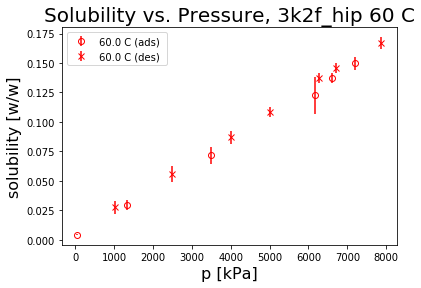

In [13]:
# COMPUTE AND PLOT SOLUBILITY
reload(errprop)
reload(dataproc)
reload(plot)
# Drop volume [uL]
v_drop_eq = df['drop volume [uL]'].to_numpy(dtype=float)
# Use fractional change in drop volume from atmospheric pressure to estimate sample volume
df['sample volume [mL]'] = v_samp

# calculate "actual gas weight gain" with buoyancy correction; volumes in mL, density in g/mL
w_buoy = dataproc.rho_co2(df['p actual [kPa]'].to_numpy(dtype=float), T)*(v_samp + v_ref_he)
df['buoyancy correction [g]'] = w_buoy
# calculate solubility w/w
w_gas_act = df['actual weight of dissolved gas [g]'].to_numpy(dtype=float)
solubility = w_gas_act / (w_poly + w_gas_act)
df['solubility [w/w]'] = solubility

# propagate the error in the solubility
s_solubility = errprop.error_solubility(solubility, v_samp, w_buoy, w_gas_act, v_drop_eq, 
                                    s_v_drop,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
df['solubility error [w/w]'] = s_solubility

# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s %d C' % (polyol, T))

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

#### Plot with Previous Data

Since we have already measured the solubility of 3k2f at 60 C for pressures up to almost 5.5 MPa, we can explore the repeatability of these experiments by comparing our previous measurements with the present measurements.

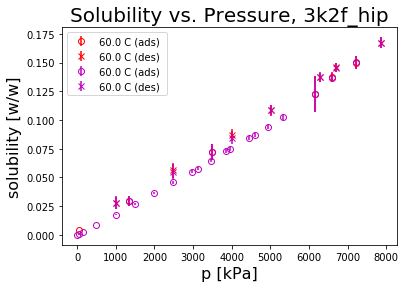

In [14]:
reload(plot)
# plot solubility vs. p
ax = plot.plot_errorbars_ads_des(p_plot, solubility, s_solubility, p_set_arr, T, color='r', xlabel='p [kPa]',
                                ylabel='solubility [w/w]', title='Solubility vs. Pressure, %s' % (polyol))
df_prev = pd.read_csv('..\\g-adsa_results\\3k2f_60c.csv')
p_prev = df_prev['p actual [kPa]'].to_numpy(dtype=float)
solubility_prev = df_prev['solubility [w/w]'].to_numpy(dtype=float)
s_solubility_prev = df_prev['solubility error [w/w]'].to_numpy(dtype=float)
ax = plot.plot_errorbars_ads_des(p_prev, solubility_prev, s_solubility_prev, p_prev, 60, ax=ax, color='m')
plt.legend()

# save figure
if save_plots:
    plt.savefig(save_folder + 'solub_%s_%dc_repeatability.pdf' % (polyol, T), bbox_inches='tight')

They match (more-or-less)! The remaining discrepancies appear to be of the same scale as those of the drop volume, correcting which is a more laborious task, so I will satisfy myself with the present success and extend the analysis to the specific volume.

### Specific Volume

The specific volume is calculated as

\begin{align*}
    v(p) &= \frac{V_{samp}(p)}{W_{gas} + W_{poly}} \\
\end{align*}

for which we have already calculated the necessary values.

(1, 1.1)

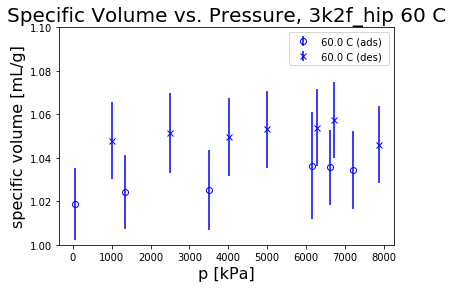

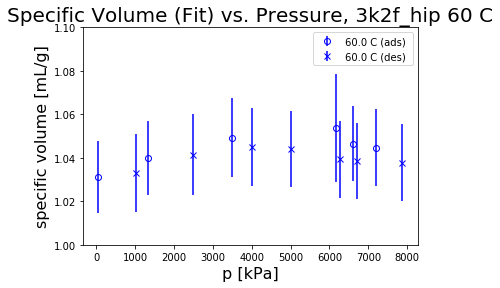

In [16]:
reload(errprop)

# calculate specific volume
spec_vol = v_samp / (w_gas_act + w_poly)
df['specific volume [mL/g]'] = spec_vol
# also compute the specific volume based on the quadratic fit of the drop volume
spec_vol_fit = v_samp_fit / (w_gas_act + w_poly)

# propagate error to estimate uncertainty
s_spec_vol = errprop.error_spec_vol(spec_vol, v_samp, w_buoy, w_gas_act, v_drop_eq, 
                                    s_v_drop,  w_poly_arr, s_frac_rho_co2, w_samp_ref, s_w_samp_ref,
                                    rho_samp_ref, s_rho_samp_ref, v_samp_ref, v_drop_ref, s_v_drop_ref, 
                                    v_ref, s_v_ref, s_mp1, s_zero, s_w_gas_ref)
df['specific volume error [mL/g]'] = s_spec_vol

# save results
df.to_csv(save_folder + save_data_name)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol, s_spec_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                                 ylabel='specific volume [mL/g]', title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([1, 1.1])

# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')
    
# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol_fit, s_spec_vol, p_set_arr, T, color='b', xlabel='p [kPa]', 
                             ylabel='specific volume [mL/g]', title='Specific Volume (Fit) vs. Pressure, %s %d C' % (polyol, T))
ax.set_ylim([1, 1.1])

Again, as a check, we compare these results with those obtained before using the automatic test.

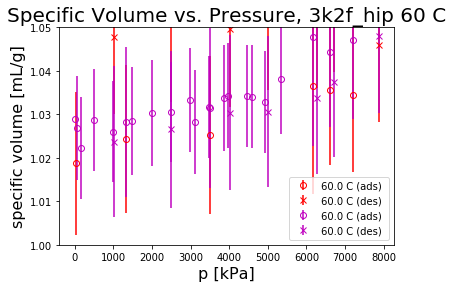

In [17]:
# load previous specific volume data
spec_vol_prev = df_prev['specific volume [mL/g]'].to_numpy(dtype=float)
s_spec_vol_prev = df_prev['specific volume error [mL/g]'].to_numpy(dtype=float)

# Plot specific volume vs. pressure
ax = plot.plot_errorbars_ads_des(p_plot, spec_vol, s_spec_vol, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                 ylabel='specific volume [mL/g]', title='Specific Volume vs. Pressure, %s %d C' % (polyol, T))
ax = plot.plot_errorbars_ads_des(p_prev, spec_vol_prev, s_spec_vol_prev, p_prev, 60, ax=ax, color='m')
ax.set_ylim([1, 1.05])
plt.legend(loc=4)
# save figure
if save_plots:
    plt.savefig(save_folder + 'spec_vol_%s_%dc_comp.pdf' % (polyol, T), bbox_inches='tight')

Thanks to those forgiving error bars, we can conclude that the measurements of specific volume are consistent. Interestingly, by reaching higher pressures, the specific volume noticeably increases, as observed before in Di Caprio et al. *Fl. Ph. Equil.* (2016).

Having computed the specific volume, we store it as the sample density along with the density of the carbon dioxide atmosphere for use in FTA32 software to compute the interfacial tension properly.

In [18]:
reload(dataproc)
t_grav_sec = t_grav*60
# Store densities of CO2 atmosphere and sample in csv file
for i in range(len(adsa_t0_list)):
    adsa_file = adsa_volume_file_list[i]
    t0 = adsa_t0_list[i]
    # build dataframe
    df_densities = dataproc.store_densities(df, adsa_folder, adsa_file, t0, t_grav_sec, p_arr, T)
    # save dataframe to csv for use in FTA32 analysis
    df_densities.to_csv(adsa_folder + adsa_file[:adsa_file.find('adsa')] + 'adsa_densities.csv', index=False)

### Interfacial Tension

At this point, I use the program `auto_density_input_fta32.py` to automatically click the right buttons in the FTA32 software to compute the interfacial tension. Once this document has been filled out, the interfacial tension can be plotted and saved below.

In [21]:
reload(dataproc)
# load interfacial tension data
if_tension = np.array([])
for i in range(len(adsa_if_tension_file_list)):
    adsa_if_tension_file = adsa_if_tension_file_list[i]
    df_if_tension = pd.read_csv(adsa_folder + adsa_if_tension_file, header=0)
    if_tension = np.concatenate((if_tension, df_if_tension['Interfacial Tension [mN/m]'].to_numpy(dtype=float)))

# has interfacial tension data been provided?
if len(if_tension) > 0:
    # store interfacial tension for each pressure
    i_p1 = 0
    for i in range(len(p_set_arr)):
        p_set = p_set_arr[i]
        print('Pressure = %d kPa.' % p_set)
        # get indices of each measurement with pressure within thresholds
        i_p0, i_p1 = dataproc.get_curr_p_interval(p_arr, p_set, p_thresh_frac, last_bound=i_p1)
        df = dataproc.store_if_tension(if_tension, df, i, i_p0, i_p1, t_grav, t_adsa, n_adsa)

    # save results
    df.to_csv(save_folder + save_data_name)

    # extract data to plot
    if_tension_plot = df['if tension [mN/m]'].to_numpy(dtype=float)
    s_if_tension = df['if tension std [mN/m]'].to_numpy(dtype=float)
    # plot interfacial tension with errrorbars (blue color for low temperature)
    ax = plot.plot_errorbars_ads_des(p_plot, if_tension_plot, s_if_tension, p_set_arr, T, color='r', xlabel='p [kPa]', 
                                    ylabel='interfacial tension [mN/m]', 
                                     title='Interfacial Tension vs. Pressure, %s %d C' % (polyol, T))

    # save figure
    if save_plots:
        plt.savefig(save_folder + 'if_tension_%s_%dc.pdf' % (polyol, T), bbox_inches='tight')

Pressure = 45 kPa.
Interfacial tension = 25.324500 mN/m.
Pressure = 1330 kPa.
Rejected 1 outliers.
Interfacial tension = 23.014000 mN/m.


C:\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Pressure = 3500 kPa.
Interfacial tension = 18.645000 mN/m.
Pressure = 5500 kPa.
Rejected 1 outliers.
********not enough ADSA points at given pressure.******
Interfacial tension data not stored.
Pressure = 6200 kPa.
Rejected 1 outliers.
Interfacial tension = 13.601000 mN/m.
Pressure = 6600 kPa.
Rejected 1 outliers.
Interfacial tension = 12.809500 mN/m.
Pressure = 7200 kPa.
Rejected 1 outliers.
Interfacial tension = 11.789000 mN/m.
Pressure = 7850 kPa.
Rejected 1 outliers.
More than half nans, so interfacial tension data not stored.
Pressure = 6700 kPa.
Rejected 1 outliers.


IndexError: index 1768 is out of bounds for axis 0 with size 1688